**Building a dataset to analyze the correlation between GTO Fixed Income trading
with that of US Treasuries and the volatility index (MOVE Index)**

 <a id="0"></a>
# Table of Contents

[Skip to 5yr Monthly Data](#1)<br>

[Skip to 2yr Daily Data](#2)<br>

[Skip to 5yr Weekly Data](#3)<br>

    
 

In [1]:
import pandas as pd
import numpy as np
import datetime as dt 
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', None)

!pip install XlsxWriter
!pip install openpyxl
import openpyxl

     |████████████████████████████████| 153kB 11.6MB/s eta 0:00:01
     |████████████████████████████████| 245kB 17.9MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/2a/77/35/0da0965a057698121fc7d8c5a7a9955cdbfb3cc4e2423cad39
Successfully built et-xmlfile


In [2]:
move_index = "MOVE Index Data.xlsx"
move_df = pd.read_excel(move_index, sheet_name="5yr Monthly", header=1,skiprows=5)
monthly_trades = "Monthly_trade_counts_2015_2020.csv"
fi_df = pd.read_csv(monthly_trades)
treasuries_data = "monthly-us-treasury-trading-volume-sifma.xls"
treasuries_df = pd.read_excel(treasuries_data, sheet_name='Monthly', skiprows=4, header=1)

 <a id="1"></a>
 
 **Cleaning up the Monthly data**

In [3]:


total_trades = fi_df[['Date','Non Premium']]
total_trades['Non Premium'] = pd.to_numeric(total_trades['Non Premium'], errors='coerce')
total_trades.groupby(['Date'])['Non Premium'].agg('sum')

total_trades.shape

(2241, 2)

In [4]:
total_trades["Date"] = pd.to_datetime(total_trades["Date"], format = '%Y%m').dt.to_period('m')
total_trades = total_trades.dropna()
total_trades = total_trades.reset_index(drop=True)
total_trades[total_trades.Date.isnull()].shape

(0, 2)

In [33]:
total_trades.dtypes

Date           period[M]
Non Premium      float64
dtype: object

In [5]:
#let's group our trades by month
total_trades.rename(columns={'Non Premium': 'FI Trades'}, inplace=True)
fimonthly_trades = total_trades.groupby(['Date'])['FI Trades'].agg('sum')
fimonthly_trades.shape

(59,)

**MOVE INDEX**

### -  needs to be cleaned up as well ###

In [6]:
move_df.dropna(inplace=True)
move_df.reset_index(drop=True, inplace=True)

move_df.dtypes

Date       object
Last Px    object
dtype: object

In [7]:
move_index= move_df[['Date','Last Px']]
move_index.rename(columns={'Last Px': 'MOVE Index'}, inplace=True)
move_index['MOVE Index'] = pd.to_numeric(move_index['MOVE Index'], errors='coerce')


move_index['Date'] = pd.to_datetime(move_index['Date'], errors='coerce')
move_index["Date"] = pd.to_datetime(move_index["Date"], format = '%Y%m').dt.to_period('m')

In [8]:
move_index.head(6)

,Date,MOVE Index
0,2020-07,40.66
1,2020-06,54.13
2,2020-05,51.55
3,2020-04,53.59
4,NaT,NaN
5,2020-03,83.87


In [9]:
#Drop those NaT values
#move_index.dropna(how='all', axis=0, inplace=True)
move_index = move_index.dropna()
move_index = move_index.reset_index(drop=True)

move_index.shape

(76, 2)

**Now let's focus on the final dateset, the monthly treasury volume produced by SIFMA**

In [10]:
treasuries_df.head(25)

#the first six rows are garbage with limited data, need to remove them
t_volume = treasuries_df.iloc[6:]

t_volume.columns

t_volume.rename(columns={'Treasury Bills': 'TBills', 'Treasury Inflation Index Securities':'TIPS',
                         'Coupon Securities Due in 2 Years or Less': '<2yr Cpn',
                         'Coupon Securities Due in More Than 3 Years but Less Than or Equal to 6 Years':'3-6yr Cpn',
                        'Coupon Securities Due in More Than 6 Years but Less Than or Equal to 7 Years':'6-7yr Cpn',
                        'Coupon Securities Due in More Than 11 Years': '>11 Cpn',
                        'Total2':'All Coupons'}, inplace=True)

tvol_df = t_volume[['Date','TBills','TIPS','<2yr Cpn','3-6yr Cpn','6-7yr Cpn','>11 Cpn','All Coupons']]
tvol_df.head()

,Date,TBills,TIPS,<2yr Cpn,3-6yr Cpn,6-7yr Cpn,>11 Cpn,All Coupons
6,2001-07-31 00:00:00,27.83925,2.50425,98.6154,67.5606,52.621,16.2258,265.366200
7,2001-08-31 00:00:00,33.33560,1.52600,88.1595,67.8796,64.0333,17.162,272.095960
8,2001-09-30 00:00:00,31.99575,1.72050,96.5377,77.5787,62.1603,17.8669,287.859900
9,2001-10-31 00:00:00,28.71780,2.54340,106.201,83.6831,60.0154,24.3447,305.504880
10,2001-11-30 00:00:00,41.97025,2.33025,133.409,110.822,79.3551,30.07,397.956113


In [11]:
tvol_df['Date'] = pd.to_datetime(tvol_df['Date'], errors='coerce')
tvol_df["Date"] = pd.to_datetime(tvol_df["Date"], format = '%Y%m').dt.to_period('m')

In [12]:

tvol_df= tvol_df.dropna()
tvol_df = tvol_df.reset_index(drop=True)
tvol_df[tvol_df.Date.isnull()].shape

(0, 8)

In [42]:
# things to go at this point:
#1. clean up the column names, particularly remove what has limited data
#2. also, need to clean up te data column to match the other dataframes

**Finally, let's combine all the dataframes into one big index**

In [13]:
df1 = pd.merge_asof(fimonthly_trades,move_index[['Date', 'MOVE Index']].sort_values('Date'),on='Date')

In [14]:
df1.head()

,Date,FI Trades,MOVE Index
0,2015-08,1689.0,87.7352
1,2015-09,1374.0,81.5650
2,2015-10,661.0,73.0792
3,2015-11,1350.0,69.8952
4,2015-12,1021.0,67.8473


In [15]:
df2 = pd.merge_asof(df1, tvol_df[['Date','TBills','TIPS',
                                  '<2yr Cpn','3-6yr Cpn',
                                  '6-7yr Cpn','>11 Cpn',
                                  'All Coupons']].sort_values('Date'),on='Date')

In [16]:
df2.shape

(59, 10)

**Run our correlations**

In [17]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid') # Set the aesthetic style of the plots

Text(0, 0.5, 'MOVE Index Values')

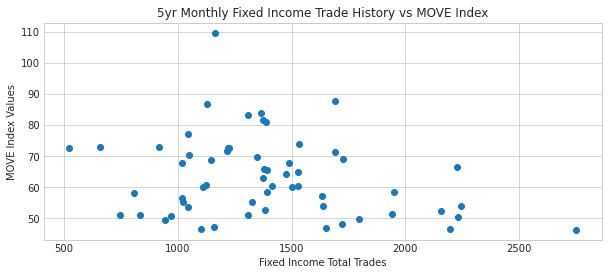

In [48]:
fig, ax = plt.subplots(figsize = (10,4))
x = df2['FI Trades']
y = df2['MOVE Index']
plt.scatter(x,y)
plt.title('5yr Monthly Fixed Income Trade History vs MOVE Index')
plt.xlabel('Fixed Income Total Trades')
plt.ylabel('MOVE Index Values')

In [18]:
import numpy as np
Y = df2['FI Trades'].values.reshape(-1, 1)  # values converts it into a numpy array
X = df2['MOVE Index'].values.reshape(-1, 1)  # values converts it into a numpy array
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

from sklearn.metrics import r2_score

r2_score(Y, Y_pred)

0.061155308474118764

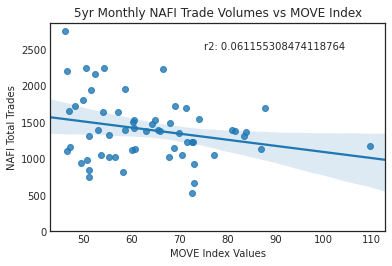

In [22]:
'''regplot  in the seaborn library  to  determine if the feature 
MOVE Index is negatively or positively correlated with NAFI Fixed Income volumes.'''
from sklearn.metrics import r2_score
import seaborn as sns
fig = plt.figure()
#fig.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)

ax.text(75,2500, 'r2: {}'.format(r2_score(Y, Y_pred), fontsize=15))

sns.regplot(x="MOVE Index",y="FI Trades", data=df2)
#plt.plot(X, Y_pred, color='red')
plt.title('5yr Monthly NAFI Trade Volumes vs MOVE Index')

plt.xlabel('MOVE Index Values')
plt.ylabel('NAFI Total Trades')
plt.ylim(0,)

plt.savefig("regplot.png", dpi = 75)

wb = openpyxl.load_workbook('FI Correlation Analysis.xlsx')
ws = wb.active

img = openpyxl.drawing.image.Image('regplot.png')
img.anchor = 'M8'

ws.add_image(img)
wb.save('FI Correlation Analysis.xlsx')


**Build multiple scater plots in the same figure**

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [20]:
df2[df2.columns[1:]].corr()['FI Trades'][1:]

MOVE Index    -0.247296
TBills         0.184784
TIPS           0.040158
All Coupons    0.033658
Name: FI Trades, dtype: float64

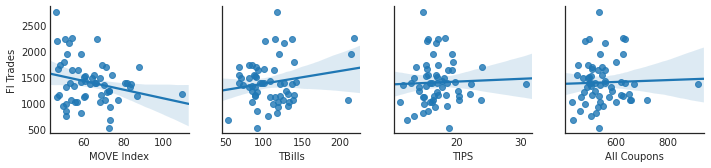

In [23]:
pp = sns.pairplot(data=df2,kind="reg",
                 y_vars=['FI Trades'],
                 x_vars=['MOVE Index','TBills','TIPS','All Coupons'])

plt.savefig("pairplots.png", dpi = 75)

# wb = openpyxl.load_workbook('FI Trade Analysis.xlsx')
# ws = wb.active

# img = openpyxl.drawing.image.Image('myplot.png')
# img.anchor = 'M8'

# ws.add_image(img)
# wb.save('FI Trade Analysis.xlsx')

plt.show()

In [54]:
#remove the column selection in the end you'll 
#get a correlation matrix of all other columns 
#you are analysing. The last [:-1] is to remove 
#correlation of 'special_col' with itself.
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('FI Correlation Analysis.xlsx', engine='xlsxwriter')
print("NAFI Trading Correlations")
nafi_corr = df2[df2.columns[1:]].corr()['FI Trades'][1:]
nafi_corr
# # Convert the dataframe to an XlsxWriter Excel object.
nafi_corr.to_excel(writer, sheet_name='5yrMonthly', startrow=2, startcol=13)

writer.save()

NAFI Trading Correlations


## Building a regression and calculate r2

In [55]:
import numpy as np
Y = df2['FI Trades'].values.reshape(-1, 1)  # values converts it into a numpy array
X = df2['MOVE Index'].values.reshape(-1, 1)  # values converts it into a numpy array
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

from sklearn.metrics import r2_score

r2_score(Y, Y_pred)

0.061155308474118764

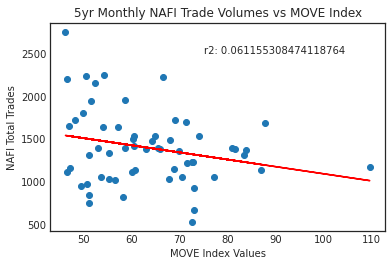

In [56]:
fig = plt.figure()
#fig.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)


ax.text(75,2500, 'r2: {}'.format(r2_score(Y, Y_pred), fontsize=15))
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.title('5yr Monthly NAFI Trade Volumes vs MOVE Index')

plt.xlabel('MOVE Index Values')
plt.ylabel('NAFI Total Trades')


#save image to excel
plt.savefig("myplot.png", dpi = 75)

wb = openpyxl.load_workbook('FI Trade Analysis.xlsx')
ws = wb.active

img = openpyxl.drawing.image.Image('myplot.png')
img.anchor = 'M8'

ws.add_image(img)
wb.save('FI Trade Analysis.xlsx')

plt.show()

In [57]:
X2 = df2[['MOVE Index']]
Y2 = df2['FI Trades']
lm = LinearRegression()

lm.fit(X2,Y2)
lm.predict(X2)
lm.score(X2,Y2)

0.061155308474118764

**Publish to data and chart to excel**

 <a id="2"></a>
    
**Now we'll work on the daily data**

[Click Here to go back to Top](#0)<br>

**Loading our datasets**

In [2]:
move_index = "MOVE Index Data.xlsx"
move_daily = pd.read_excel(move_index, sheet_name="2yr Daily", header=1,skiprows=4)
fi_daily_trades = "DailyTradeCounts_2016_2020.xlsx"
fi_trades = pd.read_excel(fi_daily_trades, sheet_name="20181201_20200730")

In [2]:
xl = pd.ExcelFile("DailyTradeCounts_2016_2020.xlsx")

xl.sheet_names  # see all sheet names

['20160101_20181130', '20181201_20200730']

In [4]:
primary_dealers = "NY Fed Primary Dealer Trade Volumes.xlsx"
dealer_volumes_df = pd.read_excel(primary_dealers, sheet_name="Sheet1")

FT_pg1 = pd.read_excel(fi_daily_trades, sheet_name="20160101_20181130")
FT_pg2 = pd.read_excel(fi_daily_trades, sheet_name="20181201_20200730")
FT_volumes = pd.concat([FT_pg1,FT_pg2])


,As Of Date,Timeseries,Value (millions)
0,2015-01-07,PDTRGSC-G11,44433
1,2015-01-14,PDTRGSC-G11,53779
2,2015-01-21,PDTRGSC-G11,48109
3,2015-01-28,PDTRGSC-G11,41320
4,2015-02-04,PDTRGSC-G11,54670


In [5]:

dealer_volumes_df = dealer_volumes_df.pivot(index="As Of Date",columns="Timeseries", values='Value (millions)') \
       .reset_index().rename_axis(None, axis=1)
dealer_volumes_df.rename(columns={'As Of Date': 'Date'}, inplace=True)

dealer_volumes_df.head()

,Date,PDTRGSC-G11,PDTRGSC-G2L3,PDTRGSC-G3L6,PDTRGSC-G6L7,PDTRGSC-G7L11,PDTRGSC-L2
0,2015-01-07,44433,51914,126481,42401,88188,70987
1,2015-01-14,53779,68112,131245,32660,105209,75816
2,2015-01-21,48109,60206,137981,27971,109938,83965
3,2015-01-28,41320,44604,106120,26450,79307,73456
4,2015-02-04,54670,61332,166651,60947,103601,105996


In [59]:
fi_trades.tail()

,Date,Client,Total Trades,Non Premium,MBS/TBA,MULTI CURRENCY TRADES,Repos,TRI-PARTY TRADES,IFT,OTHERS,ENTITY COUNT,TOTALDOWNLOADCOUNTS,MAXENTITYCOUNTMTD,TRIPARTYDEALS
18697,20200730,CIT,18340,849,459,21,0,17005,6,0,2,3050474,2,109
18698,20200730,JVB,388,17,2,0,0,369,0,0,1,29390,1,2
18699,20200730,NSI,25314,9008,2089,428,0,13031,758,0,3,4013781,3,149
18700,20200730,PPT,4951,2141,564,0,0,2052,194,0,2,218590,2,22
18701,20200730,WFS,51209,17897,4298,150,0,23942,4922,0,3,2106114,3,124


In [10]:
daily_trades = fi_trades[['Date','Non Premium']]
daily_trades['Date'] = daily_trades['Date'].astype(float)
daily_trades['Non Premium'] = pd.to_numeric(daily_trades['Non Premium'], errors='coerce')
daily_trades.head()

# total_trades = fi_df[['Date','Non Premium']]
# total_trades['Non Premium'] = pd.to_numeric(total_trades['Non Premium'], errors='coerce')
# total_trades.groupby(['Date'])['Non Premium'].agg('sum').head()

# total_trades.head()


,Date,Non Premium
0,20181201.0,0
1,20181201.0,0
2,20181201.0,0
3,20181201.0,0
4,20181203.0,28


In [19]:
daily_trades = fi_trades[['Date','Non Premium']]
daily_trades['Date'] = daily_trades['Date'].astype(float)
daily_trades['Non Premium'] = pd.to_numeric(daily_trades['Non Premium'], errors='coerce')
daily_trades.head()

daily_trades["Date"] = pd.to_datetime(daily_trades["Date"], format = '%Y%m%d').dt.to_period('d')
daily_trades = daily_trades.dropna()
daily_trades = daily_trades.reset_index(drop=True)
daily_trades[daily_trades.Date.isnull()].shape

daily_trades.rename(columns={'Non Premium': 'FI Trades'}, inplace=True)
daily_trades.shape
fidaily_trades = daily_trades.groupby('Date')['FI Trades'].sum()
 

In [21]:

fidaily_trades.head()

Date
2018-12-01         0
2018-12-03    242155
2018-12-04    283174
2018-12-05     40818
2018-12-06    292353
Freq: D, Name: FI Trades, dtype: int64

In [22]:
move_daily.dropna(inplace=True)
move_daily.reset_index(drop=True, inplace=True)

move_index= move_daily[['Date','Last Px']]
move_index.rename(columns={'Last Px': 'MOVE Index'}, inplace=True)
move_index['MOVE Index'] = pd.to_numeric(move_index['MOVE Index'], errors='coerce')
move_index['Date'] = pd.to_datetime(move_index['Date'], errors='coerce')
move_index["Date"] = pd.to_datetime(move_index["Date"], format = '%Y%m').dt.to_period('d')
move_index = move_index.dropna()
move_index = move_index.reset_index(drop=True)


In [23]:
daily_trades.head()

,Date,FI Trades
0,2018-12-01,0
1,2018-12-01,0
2,2018-12-01,0
3,2018-12-01,0
4,2018-12-03,28


In [24]:
df3 = pd.merge_asof(fidaily_trades,move_index[['Date', 'MOVE Index']].sort_values('Date'),on='Date')

In [25]:
df3.head()

,Date,FI Trades,MOVE Index
0,2018-12-01,0,52.4322
1,2018-12-03,242155,50.3104
2,2018-12-04,283174,53.8639
3,2018-12-05,40818,53.8639
4,2018-12-06,292353,60.9440


In [26]:

#Drop all rows with zero trading values, likely weekend values but not presentative of the dataset
df3=df3[df3['FI Trades']!=0].dropna()
df3=df3[df3['FI Trades']>55000].dropna()
df3.shape

(415, 3)

In [68]:

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('FI Correlation Analysis.xlsx', engine='xlsxwriter')
# Convert the dataframe to an XlsxWriter Excel object.
df2.to_excel(writer, sheet_name='5yrMonthly')
#add the correlation table
nafi_corr = df2[df2.columns[1:]].corr()['FI Trades'][1:]
nafi_corr.to_excel(writer, sheet_name='5yrMonthly', startrow=1, startcol=13)
# Get the xlsxwriter workbook and worksheet objects.
workbook  = writer.book
ws = wb.create_sheet('5yrMonthly',0) 
#worksheet = writer.sheets['5yrMonthly']

# Convert the 2yr daily dataframe to an XlsxWriter Excel object.
df3.to_excel(writer, sheet_name='2yrDaily')
#add a correlation table
nafi_daily_corr = df3[df3.columns[1:]].corr()['FI Trades'][1:]
nafi_daily_corr.to_excel(writer, sheet_name='2yrDaily', startrow=1, startcol=7)
# Get the xlsxwriter workbook and worksheet objects.
workbook  = writer.book
ws = wb.create_sheet('2yrDaily',1) 


writer.save()

**Calculate our regressions**

In [69]:
import numpy as np
from sklearn.metrics import r2_score

#Monthly regression
Y_mo = df2['FI Trades'].values.reshape(-1, 1)  # values converts it into a numpy array
X_mo = df2['MOVE Index'].values.reshape(-1, 1)  # values converts it into a numpy array
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X_mo, Y_mo)  # perform linear regression
Y_pred = linear_regressor.predict(X_mo)  # make predictions

#Daily regression
Y_da = df3['FI Trades'].values.reshape(-1, 1)  # values converts it into a numpy array
X_da = df3['MOVE Index'].values.reshape(-1, 1)  # values converts it into a numpy array
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X_da, Y_da)  # perform linear regression
y_pred = linear_regressor.predict(X_da)  # make predictions

print("Monthly r2: {}".format(r2_score(Y_mo, Y_pred)))
print("Daily r2: {}".format(r2_score(Y_da, y_pred)))

#print('The value is {0}'.format(row['num']))

Monthly r2: 0.061155308474118764
Daily r2: 0.4131056736003903


**Plotting the Monthly Regression**

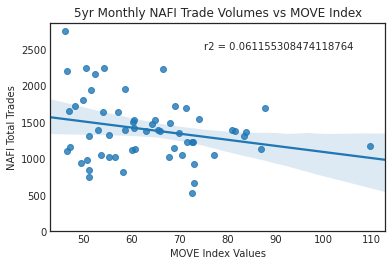

In [70]:
'''regplot  in the seaborn library  to  determine if the feature 
MOVE Index is negatively or positively correlated with NAFI Fixed Income volumes.'''
from sklearn.metrics import r2_score
import seaborn as sns
fig = plt.figure()
#fig.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)

ax.text(75,2500, 'r2 = {}'.format(r2_score(Y_mo, Y_pred), fontsize=15))

sns.regplot(x="MOVE Index",y="FI Trades", data=df2)
#plt.plot(X, Y_pred, color='red')
plt.title('5yr Monthly NAFI Trade Volumes vs MOVE Index')

plt.xlabel('MOVE Index Values')
plt.ylabel('NAFI Total Trades')
plt.ylim(0,)

plt.savefig("monthly_regplot.png", dpi = 75)

wb = openpyxl.load_workbook('FI Correlation Analysis.xlsx')
wb.active = 0
ws = wb.active


img = openpyxl.drawing.image.Image('monthly_regplot.png')
img.anchor = 'M8'

ws.add_image(img)
wb.save('FI Correlation Analysis.xlsx')


**Plotting the daily regression**

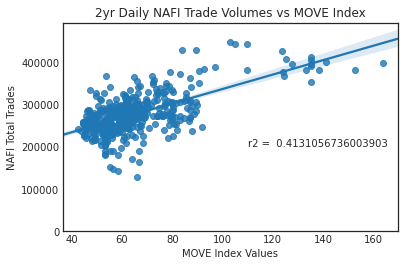

In [71]:
'''regplot  in the seaborn library  to  determine if the feature 
MOVE Index is negatively or positively correlated with NAFI Fixed Income volumes.'''
from sklearn.metrics import r2_score
import seaborn as sns
fig = plt.figure()
#fig.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)

ax.text(110,200000, 'r2 =  {}'.format(r2_score(Y_da, y_pred), fontsize=15))

sns.regplot(x="MOVE Index",y="FI Trades", data=df3)
#plt.plot(X, Y_pred, color='red')
plt.title('2yr Daily NAFI Trade Volumes vs MOVE Index')

plt.xlabel('MOVE Index Values')
plt.ylabel('NAFI Total Trades')
plt.ylim(0,)

plt.savefig("daily_regplot.png", dpi = 75)

wb = openpyxl.load_workbook('FI Correlation Analysis.xlsx')
wb.active = 1
ws = wb.active

img = openpyxl.drawing.image.Image('daily_regplot.png')
img.anchor = 'E5'

ws.add_image(img)
wb.save('FI Correlation Analysis.xlsx')


**Plotting 5yr correlations**

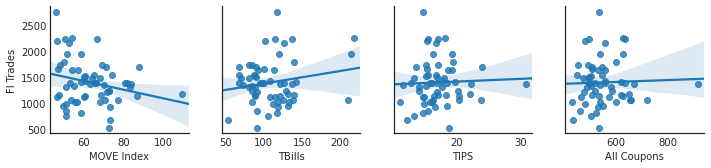

In [72]:
pp = sns.pairplot(data=df2,kind="reg",
                 y_vars=['FI Trades'],
                 x_vars=['MOVE Index','TBills','TIPS','All Coupons'])

plt.savefig("monthly_corr.png", dpi = 75)

wb = openpyxl.load_workbook('FI Correlation Analysis.xlsx')
wb.active = 1
ws = wb.active

img = openpyxl.drawing.image.Image('monthly_corr.png')
img.anchor = 'M25'

ws.add_image(img)
wb.save('FI Correlation Analysis.xlsx')

 <a id="3"></a>

**Run our regressions over a 5yr period for weekly data**

[Click Here to go back to Top](#0)<br>


In [2]:
# import pandas as pd

fi_daily_trades = "DailyTradeCounts_2016_2020.xlsx"
FT_pg1 = pd.read_excel(fi_daily_trades, sheet_name="20160101_20181130")
FT_pg2 = pd.read_excel(fi_daily_trades, sheet_name="20181201_20200730")
FT_volumes = pd.concat([FT_pg1,FT_pg2])

primary_dealers = "NY Fed Primary Dealer Trade Volumes.xlsx"
dealer_volumes_df = pd.read_excel(primary_dealers, sheet_name="Sheet1")

In [3]:
#Clean up the date format first
from datetime import datetime
FT_volumes['Date'] = pd.to_datetime(FT_volumes['Date'].astype(str), format='%Y-%m-%d')
#rename the non-premium column so it's clear we're working with FI trades
FT_volumes.rename(columns={'Non Premium': 'FI Trades'}, inplace=True)
#convert daily data to weekly for each client
weekly_trades = FT_volumes.groupby("Client").resample('W-Wed', 
                                                        label='right', closed = 'right', on='Date').sum().reset_index().sort_values(by='Date')

#We could have only done the following simple resample if the datetime object was in the form
#of a datetime or PeriodIndex instead of the int64 of its current state.  Instead we use groupby
#to help perform the resample.
# weekly_trades = FT_volumes.resample('W').sum()

weekly_trades.reset_index(inplace=True)
weekly_trades.head()

,index,Client,Date,Total Trades,FI Trades,MBS/TBA,MULTI CURRENCY TRADES,Repos,TRI-PARTY TRADES,IFT,...,OTHERTRADES,MAXENTITY,Others,TOTALDOWNLOADCOUNTS,Enity Count,TRIPARTYDEALS,MBS/TBA,OTHERS,ENTITY COUNT,MAXENTITYCOUNTMTD
0,0,ACC,2016-01-06,101,91,10.0,0,0,0,0,...,0.0,4.0,0.0,0,4.0,0,0.0,0.0,0.0,0.0
1,2379,CNA,2016-01-06,1202,964,0.0,7,0,231,0,...,0.0,20.0,0.0,14799,20.0,8,0.0,0.0,0.0,0.0
2,245,BMO,2016-01-06,25214,18529,305.0,17,0,6363,0,...,0.0,52.0,0.0,1918523,52.0,184,0.0,0.0,0.0,0.0
3,240,AMH,2016-01-06,0,0,0.0,0,0,0,0,...,0.0,3.0,0.0,0,3.0,0,0.0,0.0,0.0,0.0
4,2139,CIT,2016-01-06,23667,2572,867.0,49,0,20104,75,...,0.0,8.0,0.0,2915808,8.0,143,0.0,0.0,0.0,0.0


In [4]:
#aggregate down the dataframe to just the date and activity

fiweekly_trades = weekly_trades.groupby(['Date'])['FI Trades'].agg('sum')
fiweekly_trades.head()

Date
2016-01-06     583640
2016-01-13    1018882
2016-01-20     868001
2016-01-27    1006613
2016-02-03    1080292
Name: FI Trades, dtype: int64

**IF necessary, we can fix our dates to account for the 1970s issue time stamp**
### from datetime import datetime

### FT_volumes['Date']=pd.to_datetime(FT_volumes['Date'], unit='s')
### pandas.to_datetime(1490772583, unit='s')

In [5]:
#now we standarize and clean up the NY Fed data


dealer_volumes_df = dealer_volumes_df.pivot(index="As Of Date",columns="Timeseries", values='Value (millions)') \
       .reset_index().rename_axis(None, axis=1)
dealer_volumes_df.rename(columns={'As Of Date': 'Date',
                                  'PDTRGSC-L2':'< 2yr duration',
                                  'PDTRGSC-G2L3':'2-3yr duration',
                                  'PDTRGSC-G3L6':'3-6yr duration',
                                  'PDTRGSC-G6L7':'6-7yr duration',
                                  'PDTRGSC-G7L11':'7-11yr duration',
                                  'PDTRGSC-G11':'> 11yr duration',
                                  }, 
                         inplace=True)

In [34]:
columnsTitles = ['Date','< 2yr duration','2-3yr duration',
                 '3-6yr duration','6-7yr duration',
                 '7-11yr duration','> 11yr duration']
cols = ['< 2yr duration','2-3yr duration',
                 '3-6yr duration','6-7yr duration',
                 '7-11yr duration','> 11yr duration']
dealer_volumes_df = dealer_volumes_df.reindex(columns=columnsTitles)
dealer_volumes_df[cols] = dealer_volumes_df[cols].apply(pd.to_numeric, errors='coerce')
dealer_volumes_df.head()

,Date,< 2yr duration,2-3yr duration,3-6yr duration,6-7yr duration,7-11yr duration,> 11yr duration
0,2015-01-07,70987,51914,126481,42401,88188,44433
1,2015-01-14,75816,68112,131245,32660,105209,53779
2,2015-01-21,83965,60206,137981,27971,109938,48109
3,2015-01-28,73456,44604,106120,26450,79307,41320
4,2015-02-04,105996,61332,166651,60947,103601,54670


In [35]:
dealer_volumes_df['Date']= pd.to_datetime(dealer_volumes_df['Date'])
dealer_volumes_df[['< 2yr duration','2-3yr duration',
                 '3-6yr duration','6-7yr duration',
                 '7-11yr duration','> 11yr duration']].astype(np.float64)

dealer_volumes_df["All Treasury Volume"] = dealer_volumes_df[cols].sum(axis=1) 
# dealer_volumes_df['> 11yr series'] = pd.to_numeric(dealer_volumes_df['> 11yr series'])
print(dealer_volumes_df.dtypes)
print(dealer_volumes_df[dealer_volumes_df['All Treasury Volume'].isnull()].shape)
dealer_volumes_df.head()

Date                   datetime64[ns]
< 2yr duration                  int64
2-3yr duration                  int64
3-6yr duration                  int64
6-7yr duration                  int64
7-11yr duration                 int64
> 11yr duration                 int64
All Treasury Volume             int64
dtype: object
(0, 8)


,Date,< 2yr duration,2-3yr duration,3-6yr duration,6-7yr duration,7-11yr duration,> 11yr duration,All Treasury Volume
0,2015-01-07,70987,51914,126481,42401,88188,44433,424404
1,2015-01-14,75816,68112,131245,32660,105209,53779,466821
2,2015-01-21,83965,60206,137981,27971,109938,48109,468170
3,2015-01-28,73456,44604,106120,26450,79307,41320,371257
4,2015-02-04,105996,61332,166651,60947,103601,54670,553197


In [36]:
#Let's combine our cleanup dataframes
df_wkly = pd.merge_asof(fiweekly_trades,dealer_volumes_df[['Date','< 2yr duration','2-3yr duration',
                 '3-6yr duration','6-7yr duration',
                 '7-11yr duration','> 11yr duration','All Treasury Volume']].sort_values('Date'),on='Date')

In [37]:
dealer_volumes_df
df_wkly.dtypes

Date                   datetime64[ns]
FI Trades                       int64
< 2yr duration                  int64
2-3yr duration                  int64
3-6yr duration                  int64
6-7yr duration                  int64
7-11yr duration                 int64
> 11yr duration                 int64
All Treasury Volume             int64
dtype: object

In [38]:
#Let's save the dataframe and create a file to add our visuals
from openpyxl import Workbook, drawing  # also import drawing namespace
from openpyxl import Workbook
wb = Workbook()

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('FI Weekly Correlation Analysis.xlsx', engine='xlsxwriter')
# Convert the dataframe to an XlsxWriter Excel object.
df_wkly.to_excel(writer, sheet_name='Weekly_correlations')
#add the correlation table
# nafi_corr = df_wkly[df_wkly.columns[1:]].corr()['FI Trades'][1:]
# nafi_corr.to_excel(writer, sheet_name='Weekly_correlations', startrow=1, startcol=13)
# # Get the xlsxwriter workbook and worksheet objects.
workbook  = writer.book
ws = wb.create_sheet('Weekly_correlations',0) 
worksheet = writer.sheets['Weekly_correlations']

#create second tab

# Convert the dataframe to an XlsxWriter Excel object.
df_wkly.to_excel(writer, sheet_name='Charts')
workbook  = writer.book
ws = wb.create_sheet('Charts',1) 
worksheet = writer.sheets['Charts']

writer.save()

In [39]:
#Calculate the covariance matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cols = ['FI Trades','< 2yr duration','2-3yr duration',
                 '3-6yr duration','6-7yr duration',
                 '7-11yr duration','> 11yr duration','All Treasury Volume']

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_std = sc.fit_transform(df_wkly[cols].iloc[:,range(0,8)].values)

cov_mat = np.cov(X_std.T)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [13]:
#Generate HeatMap for visualizing the covariance matrix

plt.figure(figsize=(8,6))
sns.set(font_scale=1.1)
hm = sns.heatmap(cov_mat, cbar=True, annot=True, 
                 square=True, fmt='.2f', annot_kws={'size':12},
                 yticklabels = cols,
                 xticklabels = cols)

plt.title('Treasury Correlation Matrix')
plt.tight_layout()

from matplotlib.patches import Rectangle
%matplotlib inline

ax = hm.ax_heatmap
ax.add_patch(Rectangle((2, 3), 1, 1, edgecolor='blue', fill=False, lw=3))

plt.show

# plt.savefig("matrix1.png", dpi = 75)

# wb = openpyxl.load_workbook('FI Weekly Correlation Analysis.xlsx')
# wb.active = 1
# ws = wb.active

# img = openpyxl.drawing.image.Image('matrix1.png')
# img.anchor = 'B2'

# ws.add_image(img)
# wb.save('FI Weekly Correlation Analysis.xlsx')



AttributeError: 'AxesSubplot' object has no attribute 'ax_heatmap'

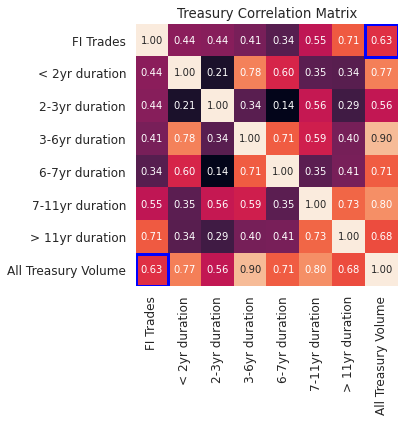

In [40]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
%matplotlib inline

plt.figure(figsize=(8,6))
sns.set(font_scale=1.1)

plt.title('Treasury Correlation Matrix')


ax = sns.heatmap(cov_mat, cbar=False, annot=True, 
                 square=True, fmt='.2f', annot_kws={'size':10},
                 yticklabels = cols,
                 xticklabels = cols)
ax.figure.tight_layout()
#this fixes the labels from getting cut off
plt.subplots_adjust(bottom=0.32)

#adding 2 heatmap cells accessed using their cell location (2,3) to change the cell color or add the border
ax.add_patch(Rectangle((7,0), 1, 1, edgecolor='blue', fill=False, lw=3))
ax.add_patch(Rectangle((0,7), 1, 1, edgecolor='blue', fill=False, lw=3))


plt.savefig("matrix3.png", dpi = 65)

plt.show()



wb = openpyxl.load_workbook('FI Weekly Correlation Analysis.xlsx')
#sets the excel tab to place the image on
wb.active = 1
ws = wb.active

img = openpyxl.drawing.image.Image('matrix3.png')
img.anchor = 'B2'

ws.add_image(img)
wb.save('FI Weekly Correlation Analysis.xlsx')



In [42]:
#The 11yr series seems to have the most correlation - let's plot that regression
from sklearn.metrics import r2_score

df_select = df_wkly[['FI Trades','> 11yr duration']]

#Wkly regression
Y_wk = df_select['FI Trades'].values.reshape(-1, 1)  # values converts it into a numpy array
X_wk = df_select['> 11yr duration'].values.reshape(-1, 1)  # values converts it into a numpy array
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X_wk, Y_wk)  # perform linear regression
Y_pred = linear_regressor.predict(X_wk)  # make predictions

#regressing against the total volumes
df_select = df_wkly[['FI Trades','All Treasury Volume']]

#Wkly regression
tY_wk = df_select['FI Trades'].values.reshape(-1, 1)  # values converts it into a numpy array
tX_wk = df_select['All Treasury Volume'].values.reshape(-1, 1)  # values converts it into a numpy array
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(tX_wk, tY_wk)  # perform linear regression
tY_pred = linear_regressor.predict(tX_wk)  # make predictions


print('The > 11yr duration weekly r^2 is: {}'.format(round(r2_score(Y_wk, Y_pred),3)))
print('All Treasury Volume r^2 is: {}'.format(round(r2_score(tY_wk, tY_pred),3)))

The > 11yr duration weekly r^2 is: 0.497
All Treasury Volume r^2 is: 0.395


In [43]:
df_select.head()

,FI Trades,All Treasury Volume
0,583640,410816
1,1018882,482166
2,868001,450443
3,1006613,413847
4,1080292,491676


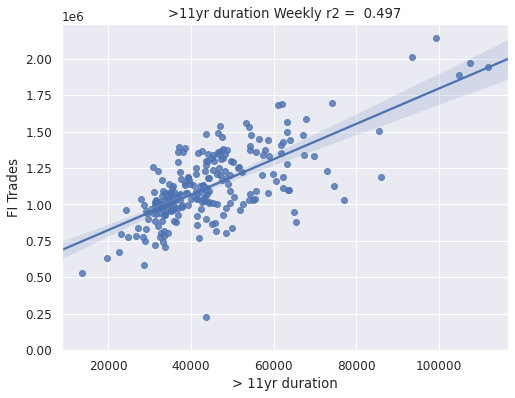

In [31]:
'''regplot  in the seaborn library  to  determine if the feature 
MOVE Index is negatively or positively correlated with NAFI Fixed Income volumes.'''
from sklearn.metrics import r2_score
import seaborn as sns

df_select = df_wkly[['FI Trades','> 11yr duration']]
plt.figure(figsize = (8,6))
#sns.regplot(df_select., df.Price)
sns.regplot(x="> 11yr duration",y="FI Trades", data=df_select)
#ax.text(1,1000000, 'r2 =  {}'.format(r2_score(Y_wk, Y_pred), fontsize=.5))
plt.title('>11yr duration Weekly r2 =  {}'.format(round(r2_score(Y_wk, Y_pred),3), fontsize = 20))

plt.ylim(0,)

plt.savefig("11yrweeklycorr2.png", dpi = 55)
plt.show()

wb = openpyxl.load_workbook('FI Weekly Correlation Analysis.xlsx')
wb.active = 1
ws = wb.active

img = openpyxl.drawing.image.Image('11yrweeklycorr2.png')
img.anchor = 'B25'

ws.add_image(img)
wb.save('FI Weekly Correlation Analysis.xlsx')



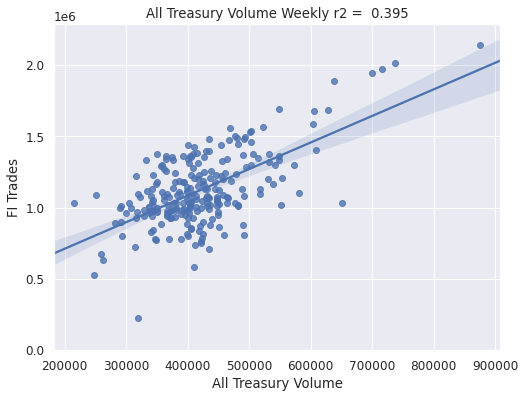

In [44]:
'''regplot  in the seaborn library  to  determine if the feature 
MOVE Index is negatively or positively correlated with NAFI Fixed Income volumes.'''
from sklearn.metrics import r2_score
import seaborn as sns

#regressing against the total volumes
df_select = df_wkly[['FI Trades','All Treasury Volume']]

plt.figure(figsize = (8,6))
#sns.regplot(df_select., df.Price)
sns.regplot(x='All Treasury Volume',y="FI Trades", data=df_select)
#ax.text(1,1000000, 'r2 =  {}'.format(r2_score(Y_wk, Y_pred), fontsize=.5))
plt.title('All Treasury Volume Weekly r2 =  {}'.format(round(r2_score(tY_wk, tY_pred),3), fontsize = 20))

plt.ylim(0,)

plt.savefig("totalweeklycorr2.png", dpi = 55)
plt.show()

wb = openpyxl.load_workbook('FI Weekly Correlation Analysis.xlsx')
wb.active = 1
ws = wb.active

img = openpyxl.drawing.image.Image('totalweeklycorr2.png')
img.anchor = 'b45'

ws.add_image(img)
wb.save('FI Weekly Correlation Analysis.xlsx')
